In [1]:
#we may need some code in the ../python directory and/or matplotlib styles
import sys
import matplotlib as mpl
sys.path.append('../python/')
os.environ['MPLCONFIGDIR'] = '../mplstyles'


#fonts
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'16', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'32'}
legend_font = {'fontname':'Arial', 'size':'22'}

#fonts global settings
mpl.rc('font',family=legend_font['fontname'])

import numpy as np
#set up a plot 
from matplotlib import pyplot as plt
#got smarter about the mpl config: see mplstyles/ directory
plt.style.use('standard')

# Joint Distributions of $E_p$ and $E_q$ with SuperCDMS Goal Resolutions

The purpose of this notebook is to detail the calculation of the joint distribution of $E_p$ and $E_q$ (the phonon and ionization energies) for SuperCDMS iZIP detectors with the SuperCDMS SNOLAB goal resolutions. Specifically, we are interested in at which energy the electron-recoil (ER) and nuclear-recoil (NR) bands overlap for a given effective nuclear-recoil Fano factor. The lower this energy is the more low-mass reach the iZIP SuperCDMS search will have in an essentially background-free environment. 

Like the notebook `QEr_2D_joint.ipynb` we will build up the distributions from conditional probability arguments beginning with the random variables and constants in the following table. 

variable/constant name|Description 
:-|:-
Y|measured ionization yield 
N|number of e/h pairs
$\delta Q$ | instrumental fluctuation on the ionization measurement
$\delta P$ | instrumental fluctuation on the phonon measurement
$E_r$ | true recoil energy
$\epsilon$ | average energy to create a single electron-hole pair for an electron-recoil in keV
$V$ |voltage across the detector in Volts
F | effective Fano factor for nuclear-recoils
F$_{er}$ |Fano factor for electron-recoils

We seek the joint distribution of $E_p$ and $E_q$ given a fixed true energy, $E_r$. It is equal to the 5-variable joint distribution integrated appropriately over the 3 unwanted variables. 

\begin{equation}
P(E_p,E_q | E_r) = \int_{-\infty}^{\infty} d(\delta P) \int_{-\infty}^{\infty} d(\delta Q) \int_0^{\infty} dN
 P(E_p,E_q,\delta P,\delta Q, N | E_r)
\end{equation}

The technique used is to write down the 5-variable joint distribution based on the rules of conditional probability and the fact that N, $\delta P$, and $\delta Q$ are independent random variables. Then the appropriate integrals can be carried out analytically or numerically.

## Resolutions

In addition to the variables already defined we need some kind of specifications for the (assumed Gaussian) resolutions on the three fundamental measured variables: N, $\delta Q$, and $\delta P$. The resolutions are denoted $\sigma_N$, $\sigma_q$, and $\sigma_p$ respectively, and are assumed to be functions of the true recoil energy $E_r$. This assumption means that for $\sigma_q$ and $\sigma_p$--which are most naturally described as functions of ionization energy and total phonon energy respectively--the arguments to the functions need to be _converted_ from the true recoil energy $E_r$ to those energy scales. In what follows this conversion is left implicit so that $\sigma_q(E_r)$ and $\sigma_p(E_r)$ are the final functions with independent variable of the true recoil energy.

Both the $\sigma_q(E_r)$ and the $\sigma_p(E_r)$ are composed of the baseline resolutions (which we call $\sigma_{0,q}$ and $\sigma_{0,p}$) in the SuperCDMS SNOLAB sensitivity paper [REF] and reasonable guesses for the energy-dependent reconstruction resolution. 

These two resolutions can therefore be modeled as follows:

\begin{equation}
\begin{aligned}
\tilde{\sigma}_q(E_{ee}) &= \sqrt{\sigma_{0,q} + \epsilon F_{er} E_{ee}} \\
\tilde{\sigma}_p(E_{ee}) &= \sqrt{\sigma_{0,p} + (V^2/\epsilon) F_{er} E_{ee}},
\end{aligned}
\end{equation}

Where $E_{ee}$ is the electron-equivalent energy for a given scatter. These functions can easily be turned into the aforementioned forms where the independent variable is the _recoil_ energy and not the _electron-equivalent_ energy, so long as one has a yield model.

The $\sigma_N$ is the standard deviation of the number of electron-hole pairs, which can be computed (for a fixed $E_r$) using the effective Fano factor F. It is given simply by:

\begin{equation}
\sigma_N(E_r) = \sqrt{F(\bar{Y}E_r/\epsilon)},
\end{equation}

Where $\bar{Y}$ is the mean ionization yield at $E_r$. Whenever $\bar{Y}$ is written it is tacitly assumed to be a function of the true recoil energy, $E_r$.

In [2]:
#constants
V=4.0
eps=3.3/1000.0
F=0.00001

#get baseline resolutions for SuperCDMS goal for iZIPs
sig0p = 0.050 #50 eV
sig0q = 0.100 #100 eV

Fer = 0.1 #Fano factor for ERs
#sigp and sigq functions for ERs
sigp = lambda E: np.sqrt(sig0p**2 + ((V/1000)**2/eps)*Fer*E)
sigq = lambda E: np.sqrt(sig0q**2 + eps*Fer*E)
sigpv = np.vectorize(sigp)
sigqv = np.vectorize(sigq)

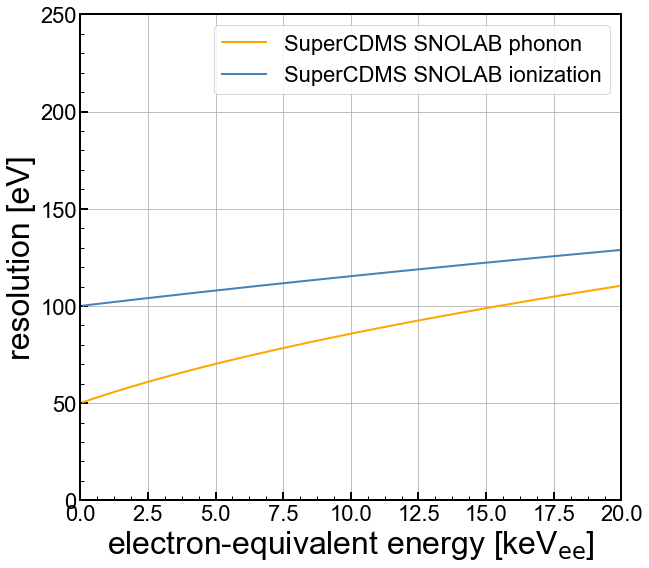

In [3]:
#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(0.1,20,0.01)

ax1.plot(X,sigpv(X)*1000,color='orange',linestyle='-',label='SuperCDMS SNOLAB phonon')
ax1.plot(X,sigqv(X)*1000,color='steelblue',linestyle='-',label='SuperCDMS SNOLAB ionization')


#ax1.axvline(t(t_test[idx]), color='k', linestyle='-', lw=2, alpha=0.8,label=None)

ymin = 0
ymax = 250

ax1.set_yscale('linear')
#ax1.set_yscale('linear')
ax1.set_xlim(0, 20) 
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel(r'electron-equivalent energy [keV$_{\mathrm{ee}}$]',**axis_font)
ax1.set_ylabel('resolution [eV]',**axis_font)
ax1.grid(True)
#ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figure.png')
plt.show()

In [4]:
#get the 2D resolution function
import prob_dist as pd
P = pd.EpEq_v2_2D_fast(sigp,sigq,V,eps) #currently using Edw ionization yield model (not Lindhard)

#test for reasonable pars
Er0 = 5
Eq0 = (0.16*Er0**0.18)*Er0
Ep0 = Er0 + (V/(1000*eps))*Eq0
print(Ep0)
print(Eq0)
print(Er0)
print(P(Ep0,Eq0,Er0))


Etest=30


#check for normalization
from scipy import integrate
limit = 1000
norm = integrate.dblquad(P, -limit, limit, -limit, limit,args=(Etest,))
print(norm)

#Pq = lambda Eq: integrate.quad(P,-100,100,args=(Eq,Etest,))[0]
#P1q = lambda Q: integrate.quad(lambda Etr,Q,Er:P1(Q,Etr,Er),lowlim,uplim,args=(Q,Etest,))[0]
#print(Pq(0.2))
#norm = integrate.quad(Pq,-100,100)
#print(norm)
#norm = integrate.quad(P1q,-0.2,4)
#print(norm)

6.295539441516669
1.0688200392512524
5
20.9906384117276
(0.0, 0)


In [5]:
import scipy
print(scipy.special.erf(10)+1)

2.0
